In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch
from torch import optim
from env import VanillaEnv
from rl.common.utils import set_seed
import time
from policy import ActorNet
from common import plot_evaluation_grid, map_conf_to_index

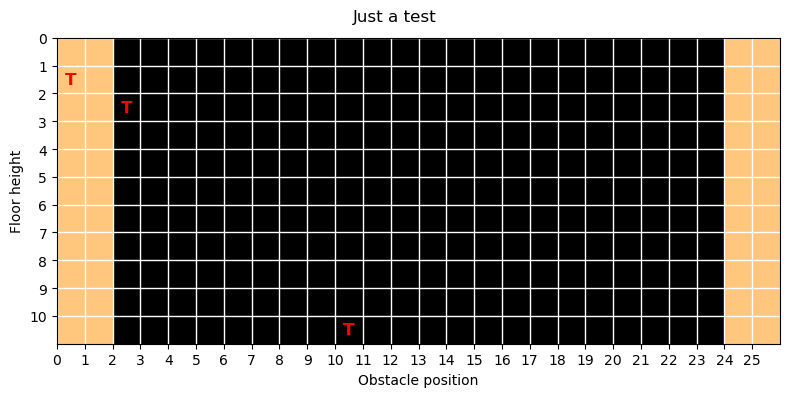

In [80]:
n_obstacle_pos = 26 # how many obstacle position you want to try out (paper: 27, max: 30)
n_floor_heights = 11 # how many floor heights you want to try out (paper: 11, max: 40)
obstacle_pos = np.rint(np.linspace(VanillaEnv.min_obstacle_pos, VanillaEnv.max_obstacle_pos, n_obstacle_pos)).astype(np.int8)
floor_height = np.rint(np.linspace(VanillaEnv.min_floor_height, VanillaEnv.max_floor_height, n_floor_heights)).astype(np.int8)

grid = np.zeros((len(obstacle_pos), len(floor_height)))

grid[1] = np.ones(11)
grid[0] = np.ones(11)
grid[-1] = np.ones(11)
grid[-2] = np.ones(11)

fig = plot_evaluation_grid(grid, [(0, 1), [2,2], [10,10]])
fig.suptitle("Just a test")
plt.show()


Loading model  bc-agent-10 - Copy.pth


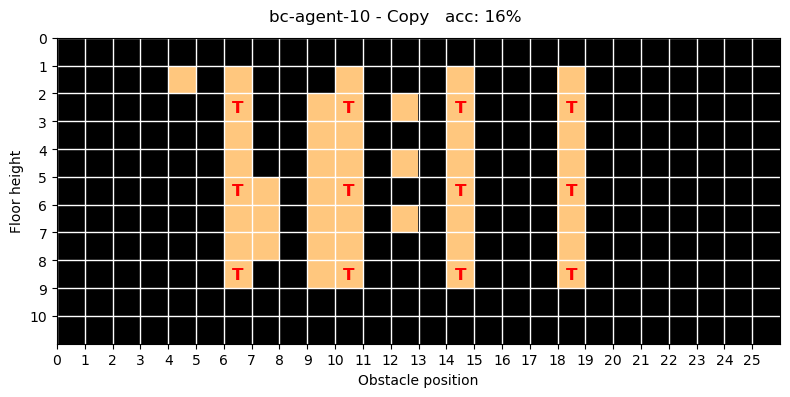

Loading model  bc-agent-10.pth


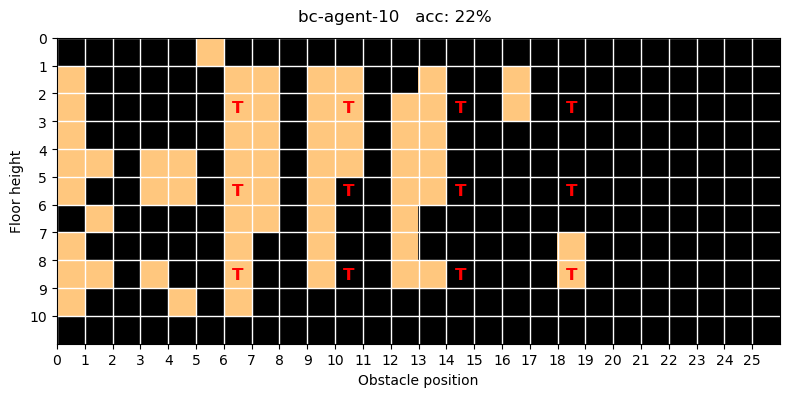

Loading model  bc-agent-100 - Copy.pth


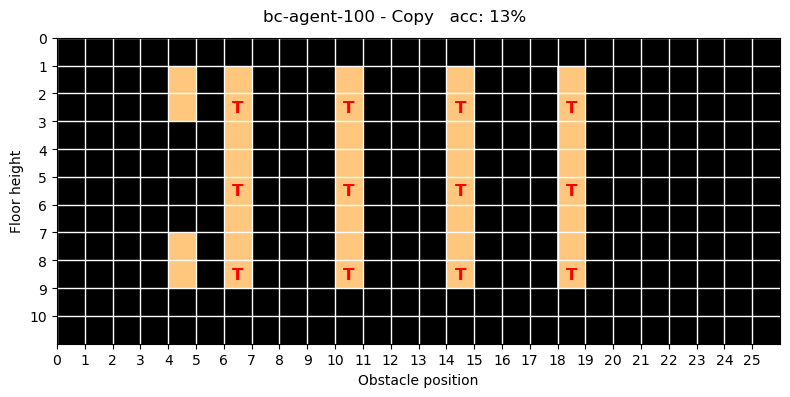

Loading model  bc-agent-100.pth


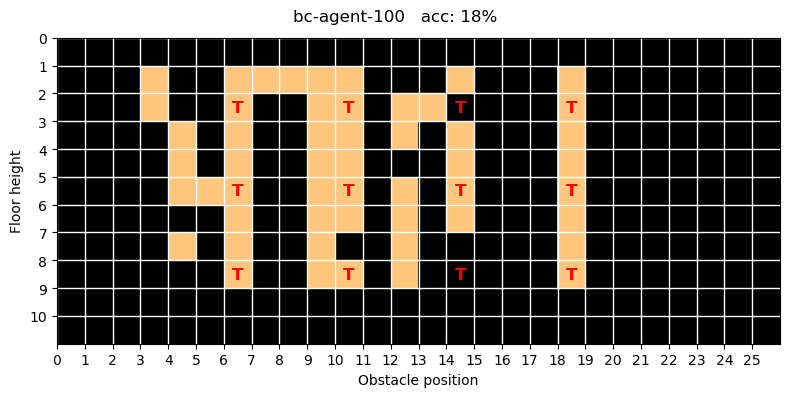

Loading model  bc-agent-20 - Copy.pth


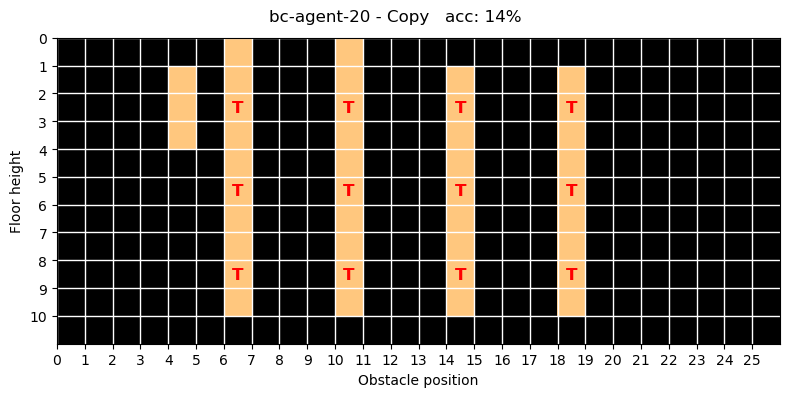

Loading model  bc-agent-20.pth


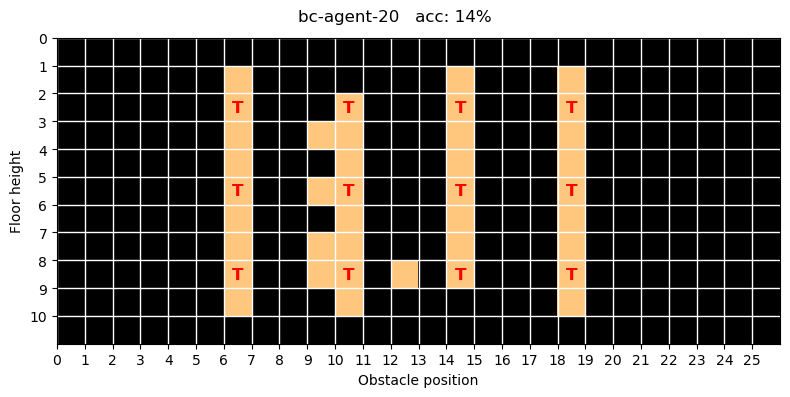

Loading model  bc-agent-30 - Copy.pth


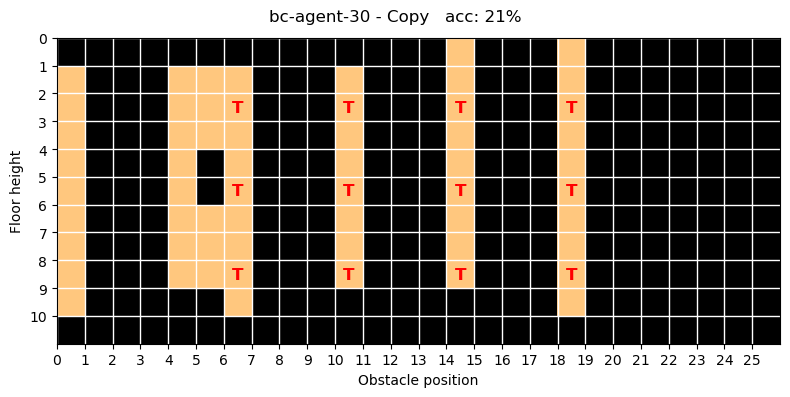

Loading model  bc-agent-30.pth


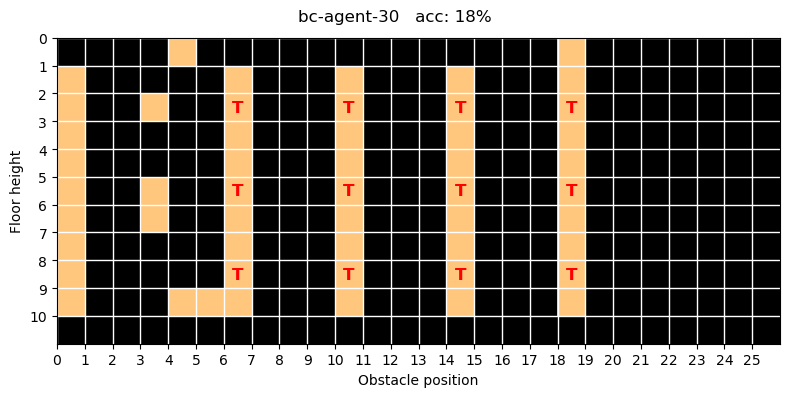

Loading model  bc-agent-40 - Copy.pth


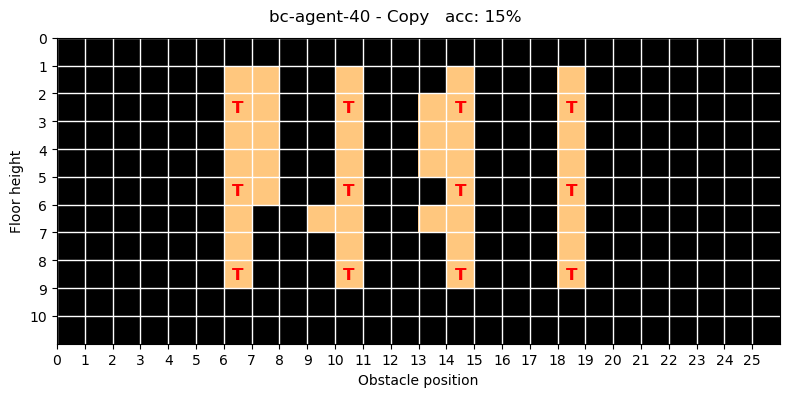

Loading model  bc-agent-40.pth


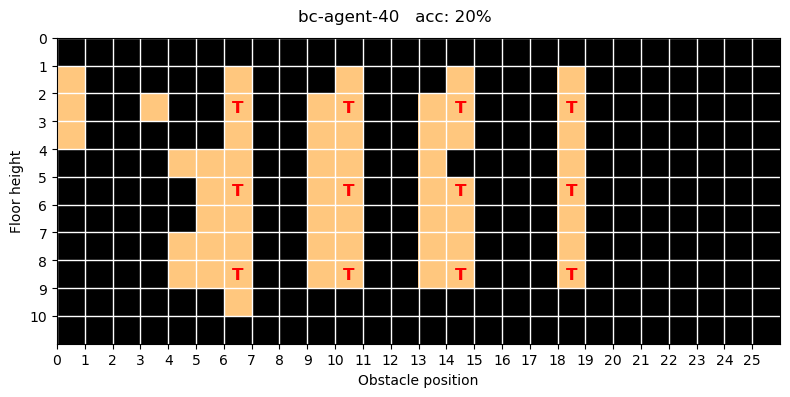

Loading model  bc-agent-50 - Copy.pth


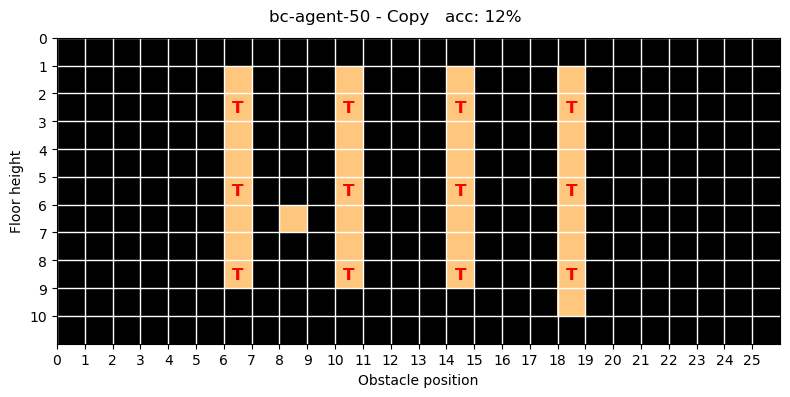

Loading model  bc-agent-50.pth


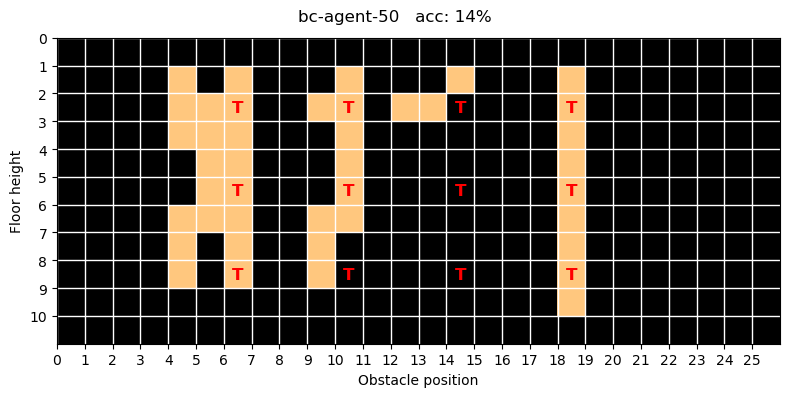

Loading model  bc-agent-60 - Copy.pth


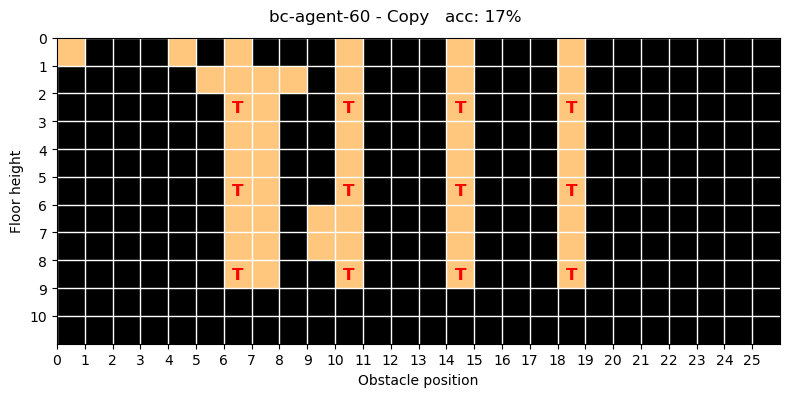

Loading model  bc-agent-60.pth


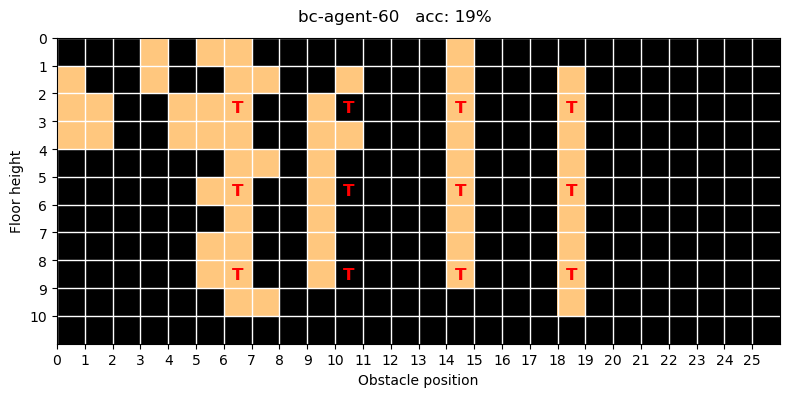

Loading model  bc-agent-70 - Copy.pth


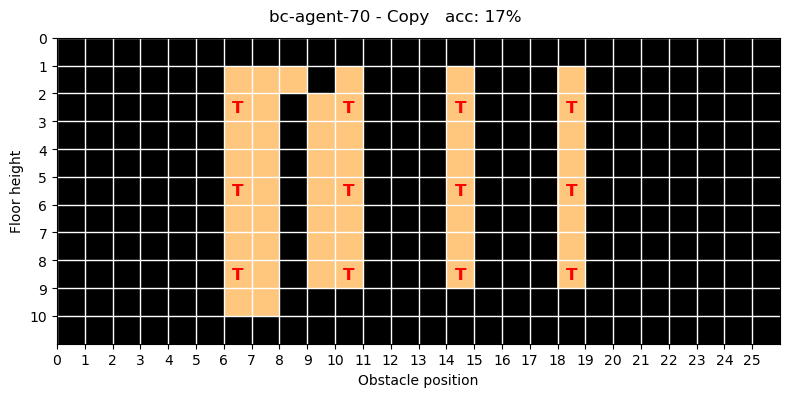

Loading model  bc-agent-70.pth


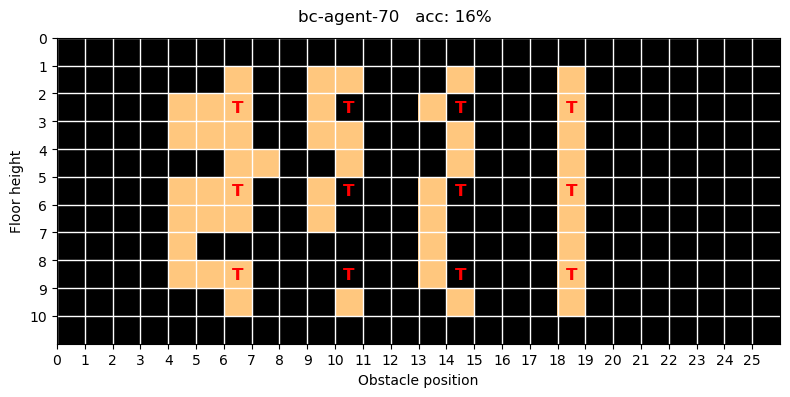

Loading model  bc-agent-80 - Copy.pth


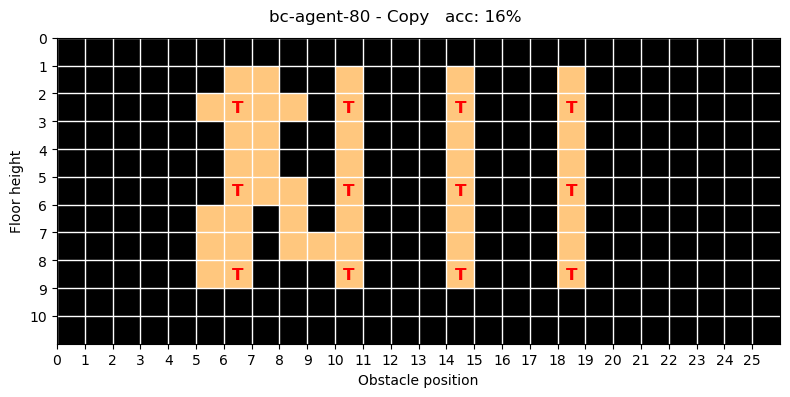

Loading model  bc-agent-80.pth


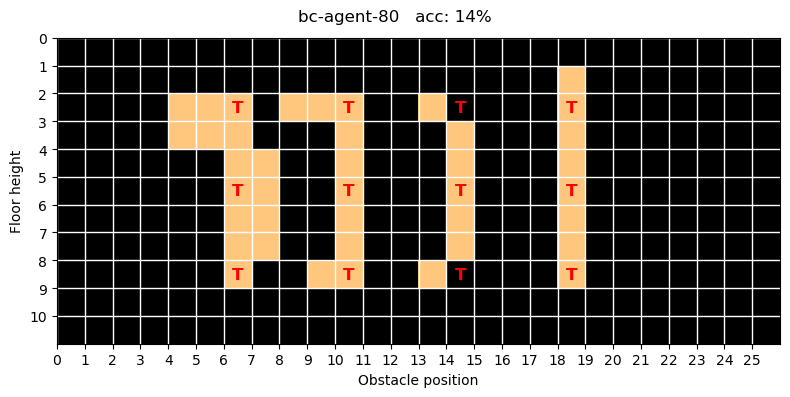

Loading model  bc-agent-90 - Copy.pth


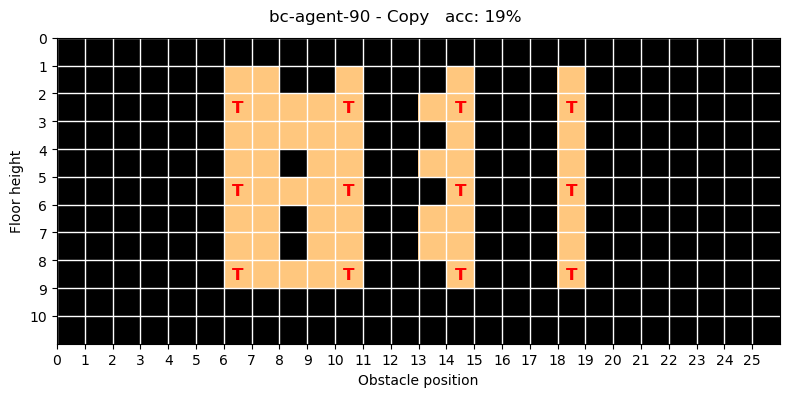

Loading model  bc-agent-90.pth


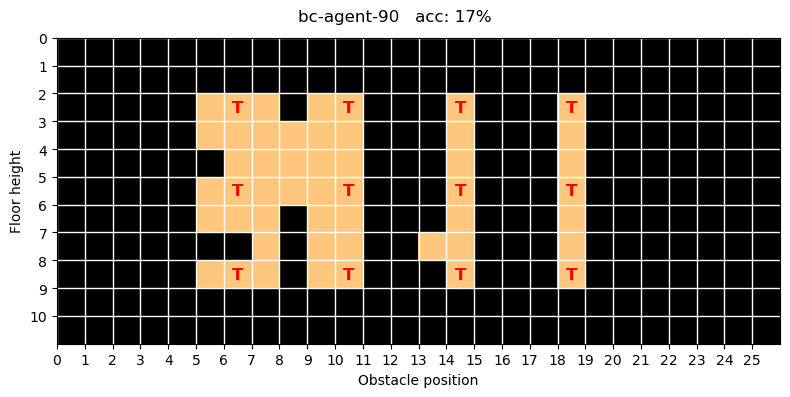

Loading model  Jun07_20-54-33_Manu-Desktop-bc.pth


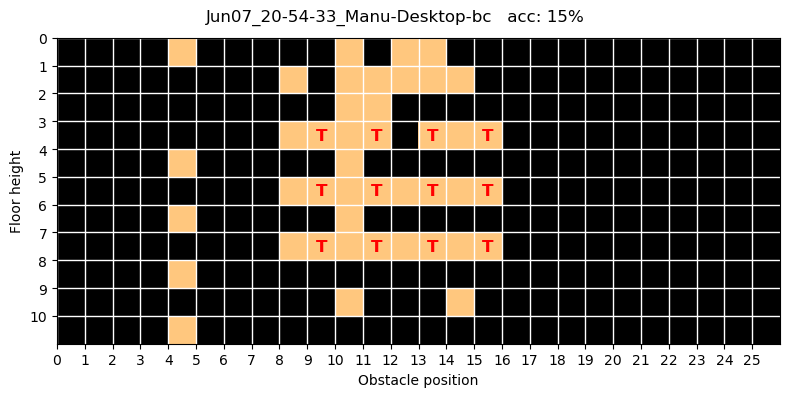

Loading model  Jun07_21-38-09_Manu-Desktop.pth


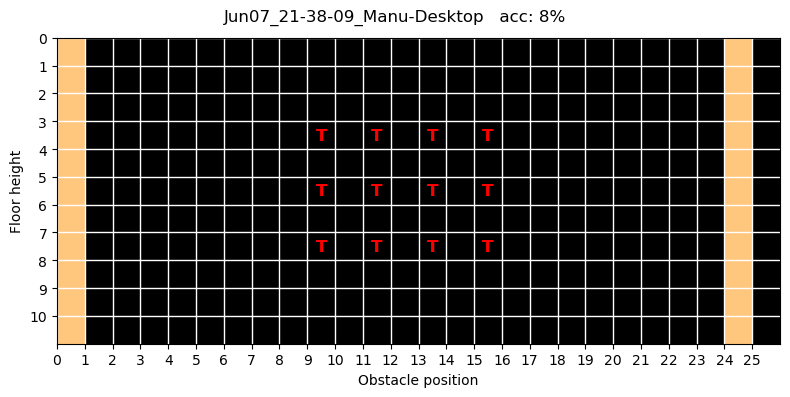

Loading model  Jun07_21-42-45_Manu-Desktop.pth


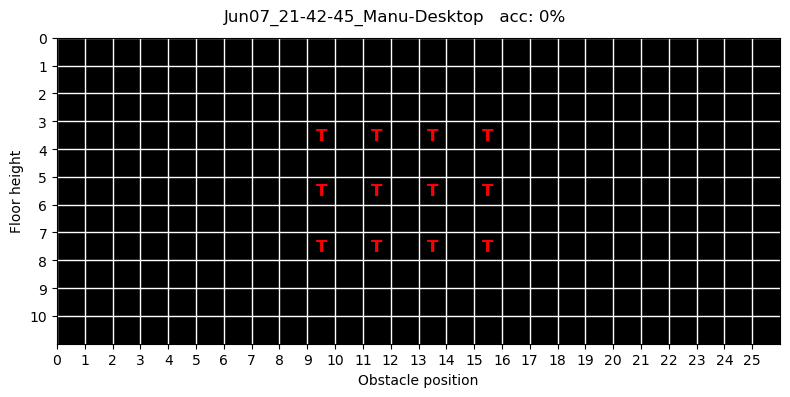

Loading model  Jun07_21-44-27_Manu-Desktop-bc.pth


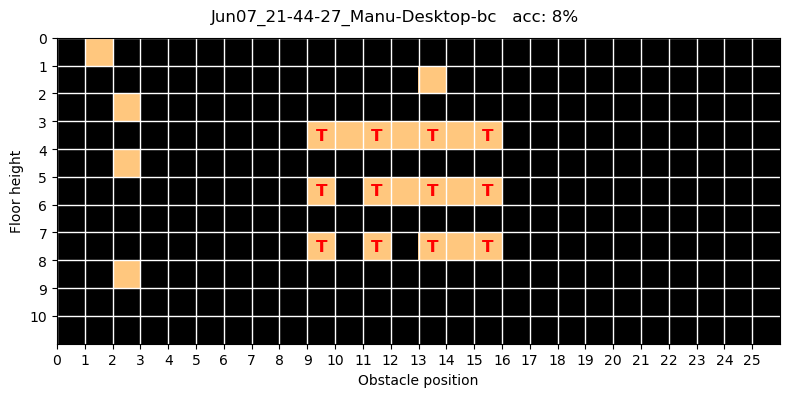

Loading model  Jun07_21-44-27_Manu-Desktop.pth


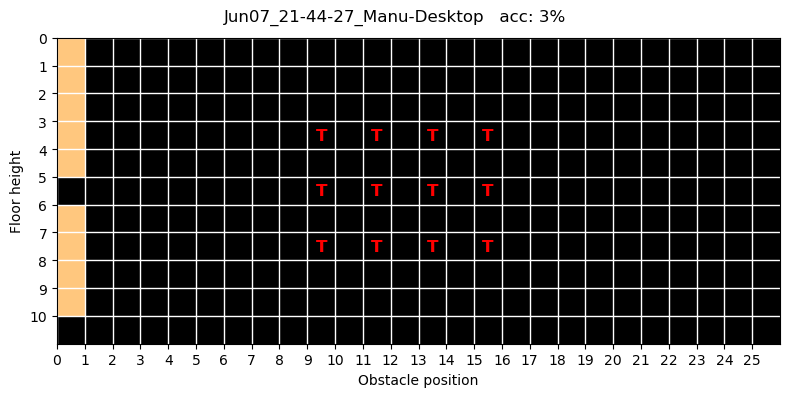

Loading model  Jun07_22-10-58_Manu-Desktop.pth


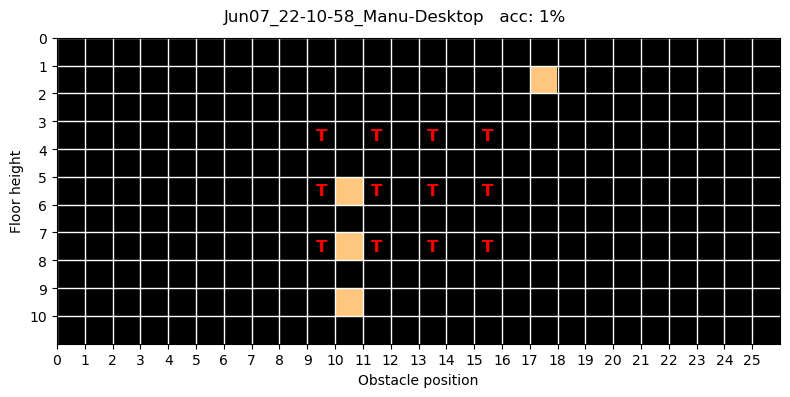

Loading model  Jun07_22-29-19_Manu-Desktop.pth


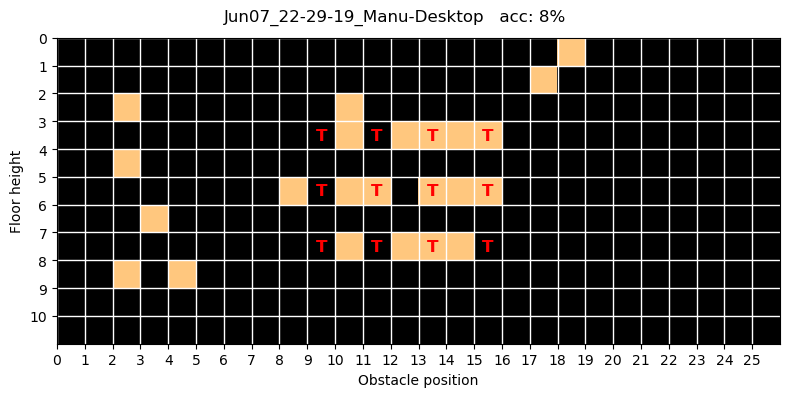

Loading model  Jun08_07-30-45_Manu-Desktop.pth


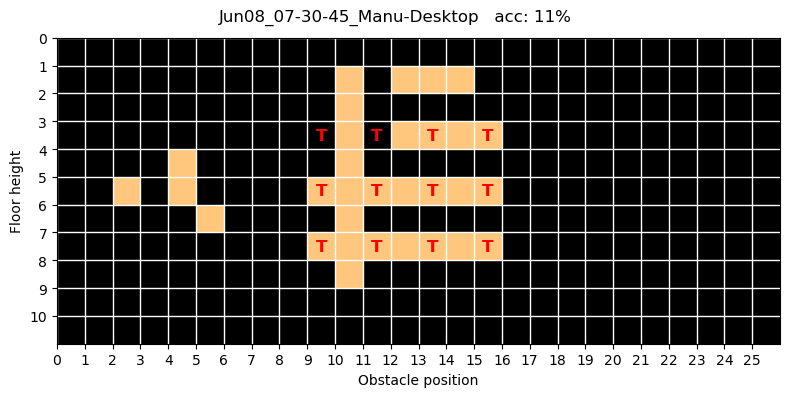

Loading model  Jun08_07-35-57_Manu-Desktop.pth


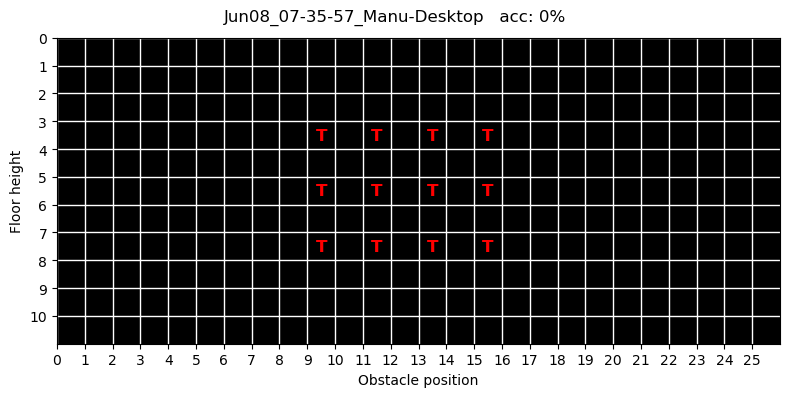

Loading model  Jun08_08-01-10_Manu-Desktop.pth


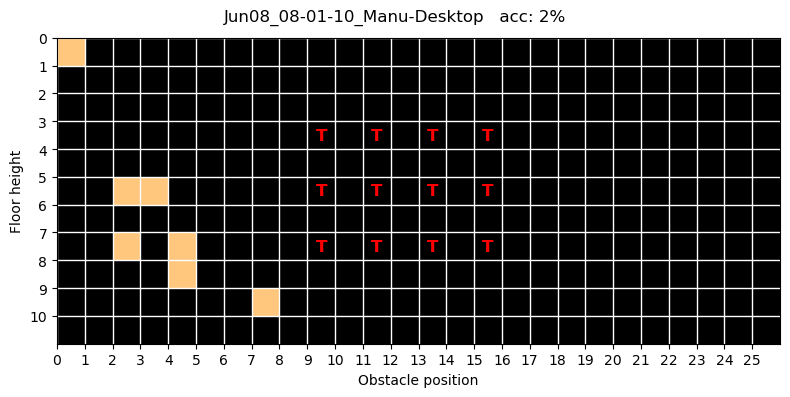

Loading model  Jun08_08-08-01_Manu-Desktop.pth


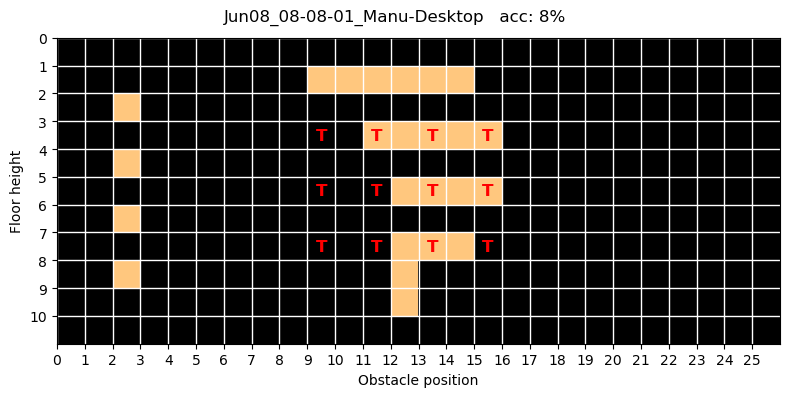

Loading model  Jun08_08-17-23_Manu-Desktop.pth


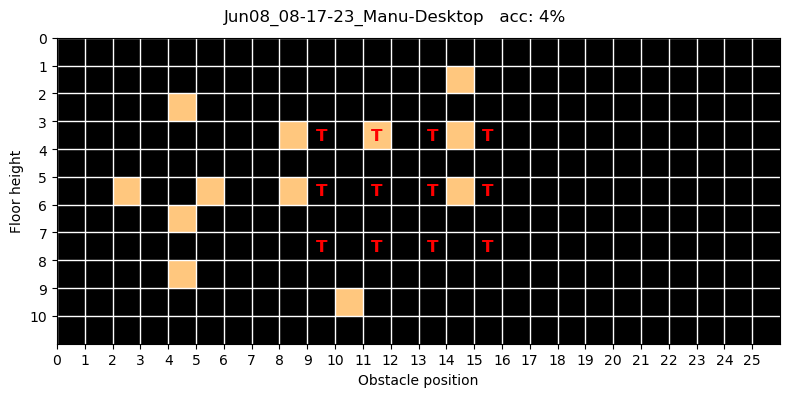

Loading model  Jun08_08-32-52_Manu-Desktop.pth


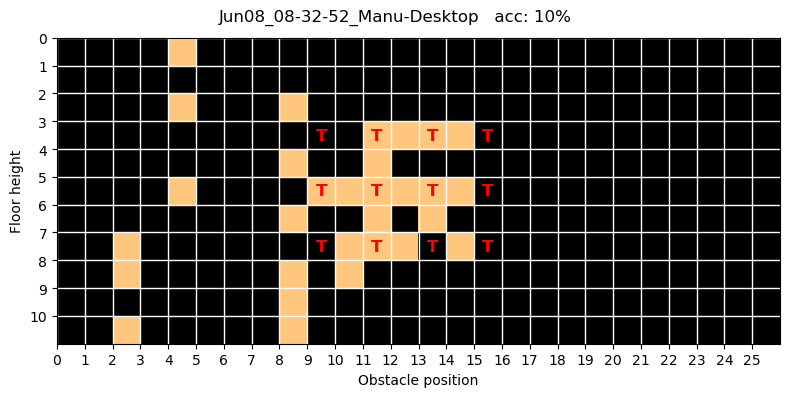

Loading model  Jun08_09-21-11_Manu-Desktop.pth


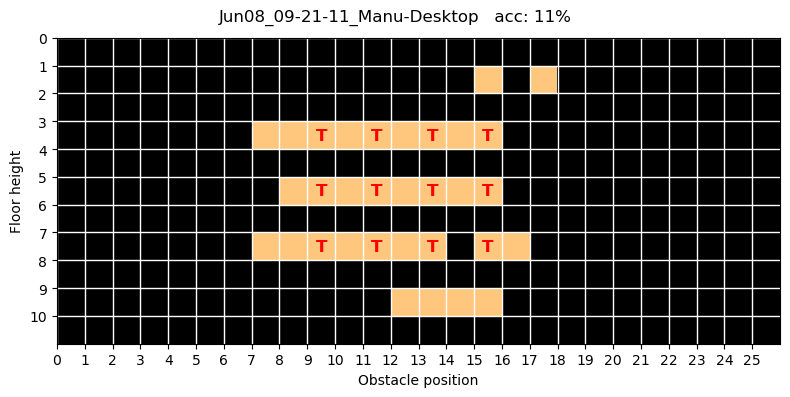

Loading model  Jun08_09-23-06_Manu-Desktop.pth


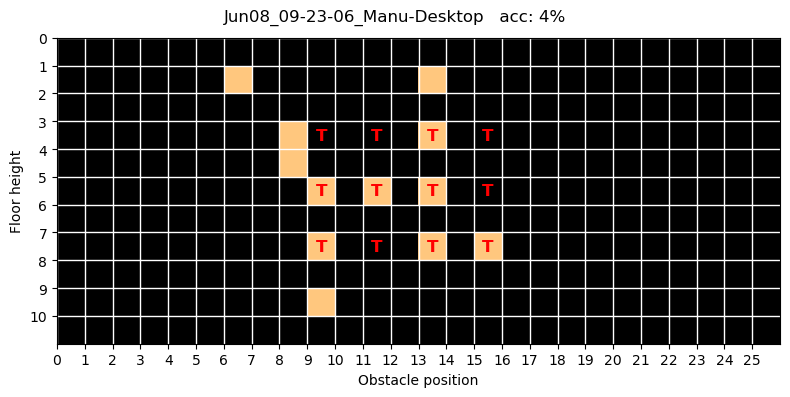

Loading model  Jun08_10-36-58_Manu-Desktop.pth


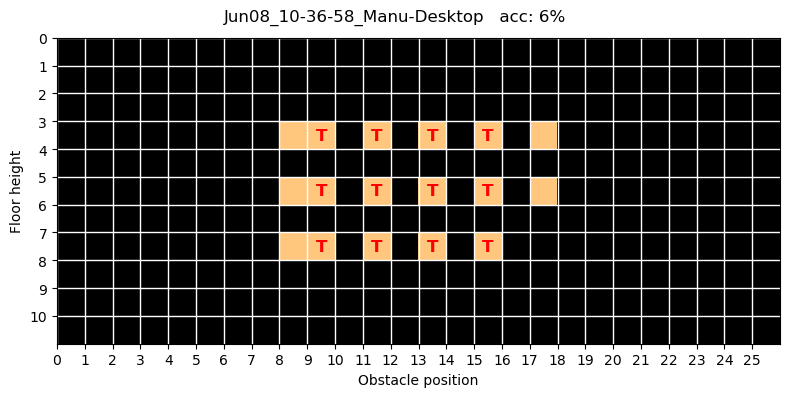

Loading model  Jun08_10-45-15_Manu-Desktop.pth


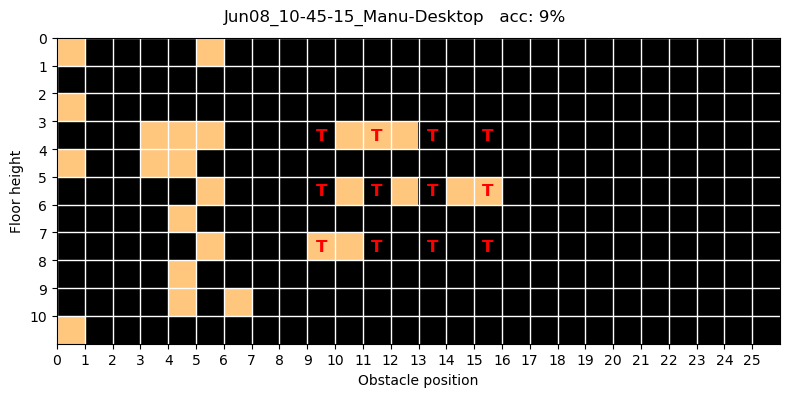

Loading model  Jun08_11-18-37_Manu-Desktop.pth


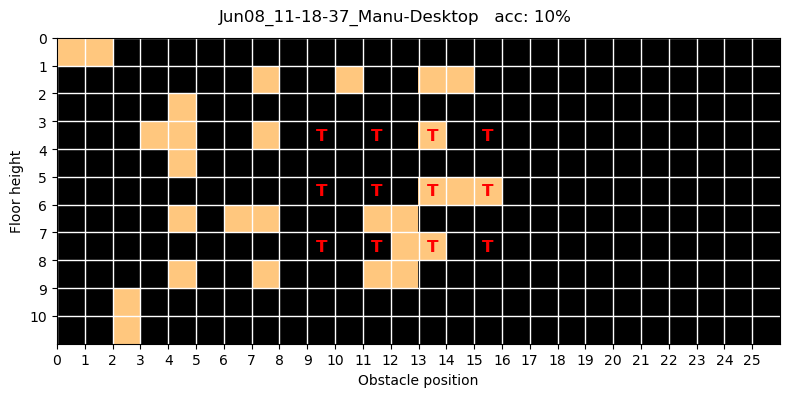

Loading model  Jun08_13-44-57_Manu-Desktop.pth


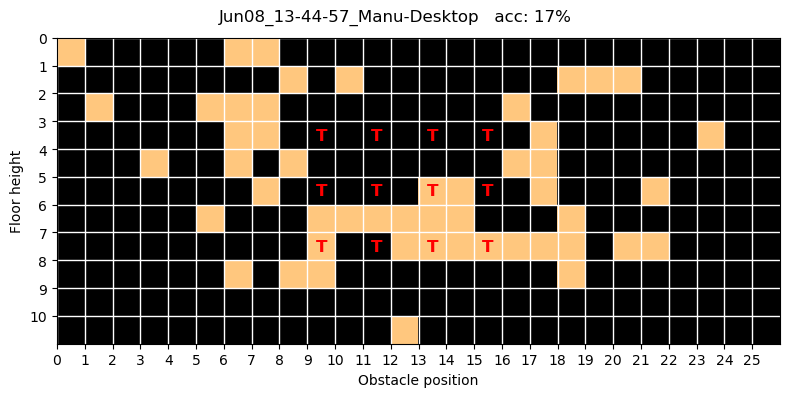

Loading model  Jun08_14-03-13_Manu-Desktop.pth


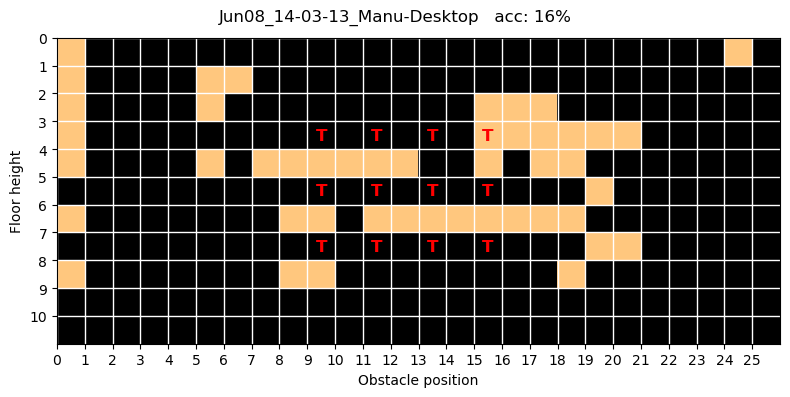

Loading model  Jun08_14-30-18_Manu-Desktop.pth


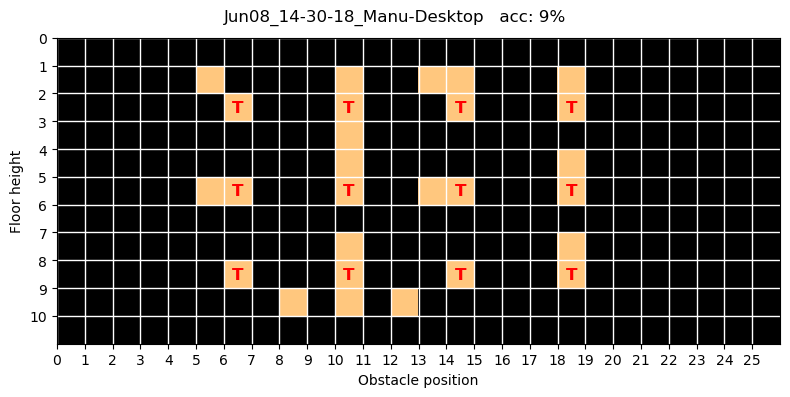

Loading model  Jun08_14-30-28_Manu-Desktop.pth


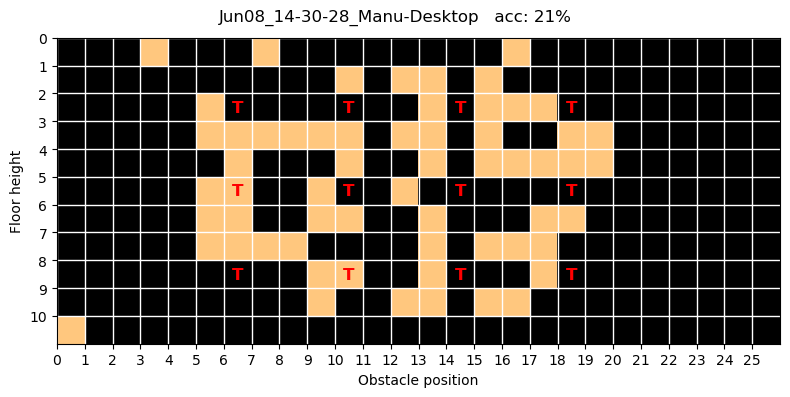

Loading model  Jun08_15-02-06_Manu-Desktop.pth


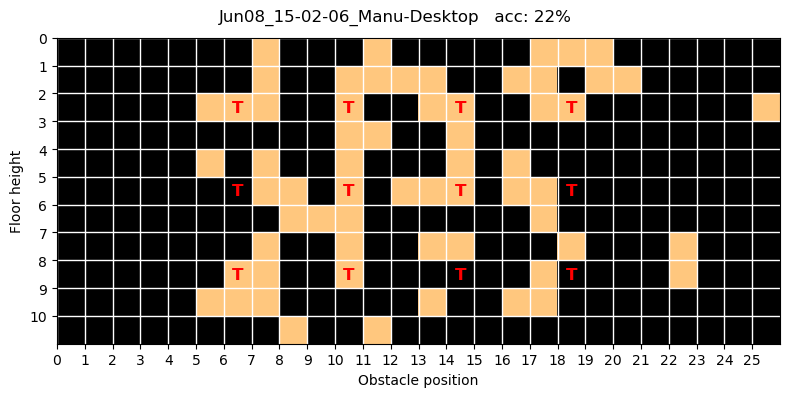

Loading model  Jun12_13-21-23_Manu-Desktop.pth


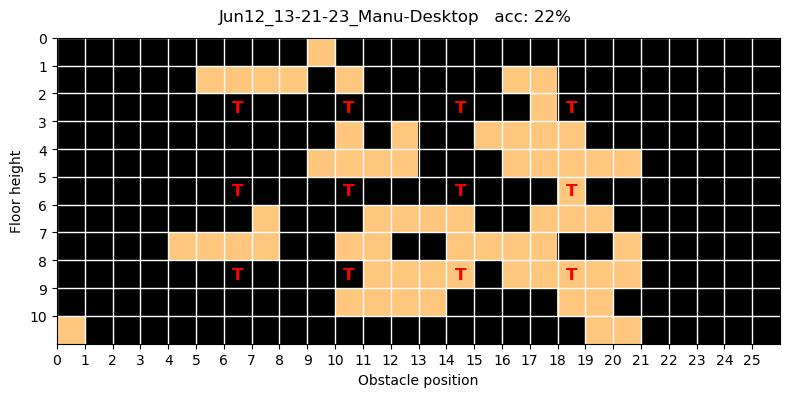

Loading model  Jun12_13-22-25_Manu-Desktop.pth


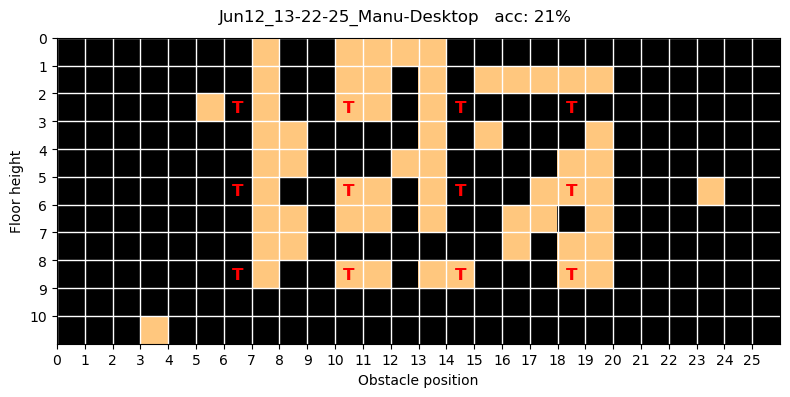

Loading model  Jun12_20-09-45_Manu-Desktop.pth


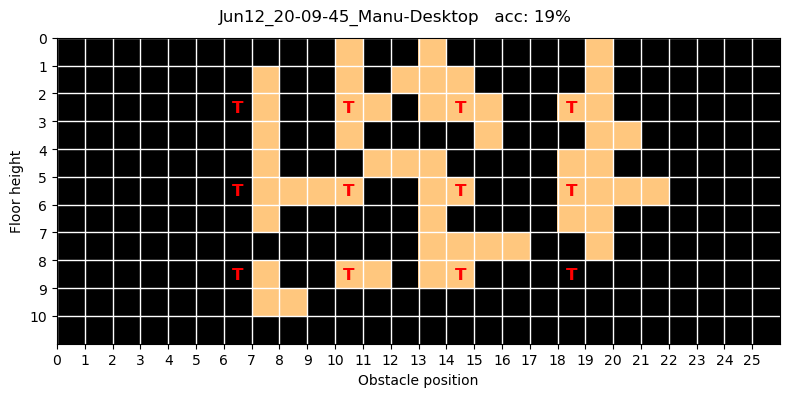

Loading model  Jun12_20-25-19_Manu-Desktop.pth


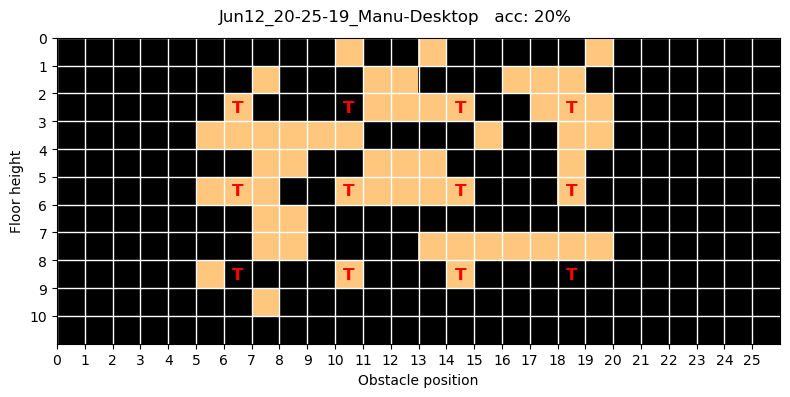

Loading model  Jun13_09-55-16_Manu-Desktop.pth


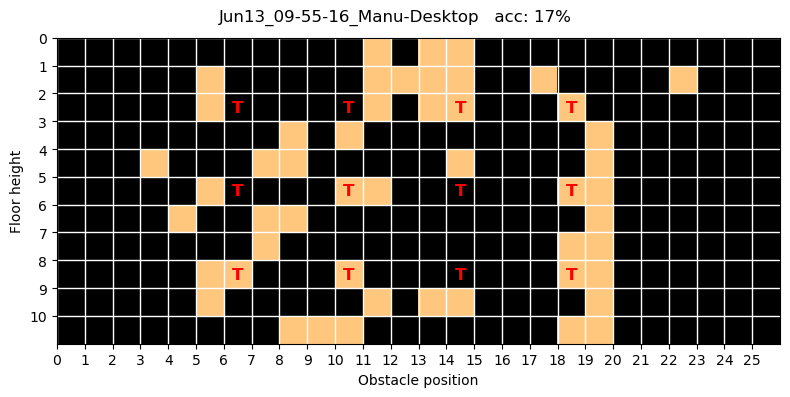

Loading model  Jun13_10-24-24_Manu-Desktop-bc.pth


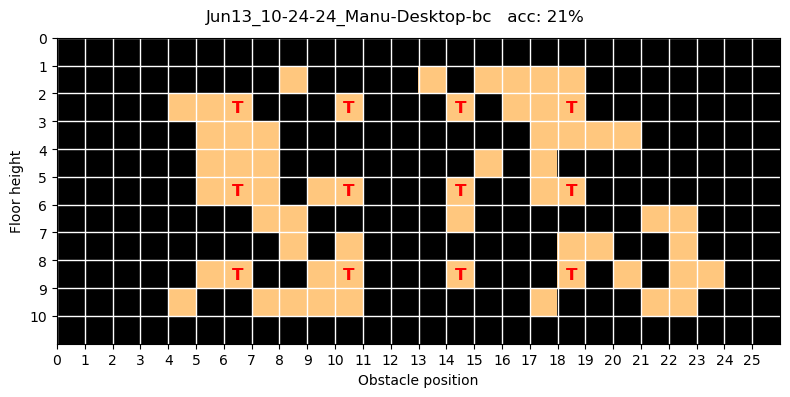

Loading model  Jun13_10-24-24_Manu-Desktop.pth


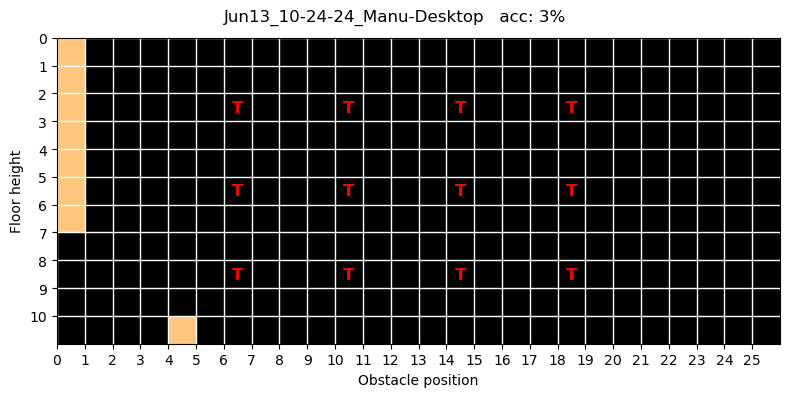

Loading model  Jun13_12-08-18_Manu-Desktop.pth


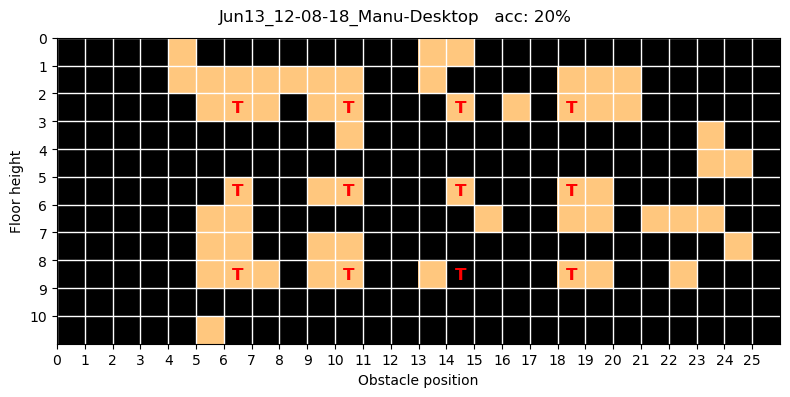

Loading model  Jun13_12-15-56_Manu-Desktop.pth


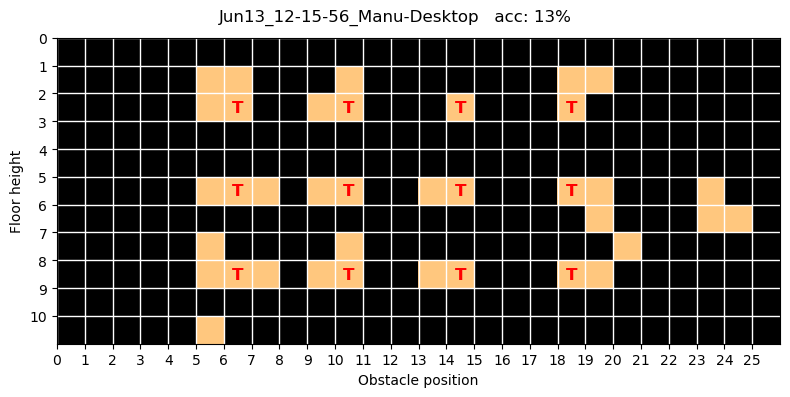

Loading model  pure_bc_without_pse-wide_grid-bc.pth


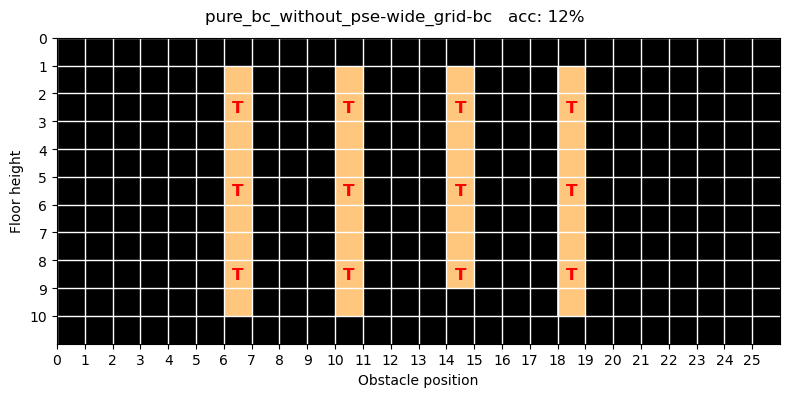

In [81]:
render = False
folder_name: str = './ckpts/'

def play_episode(model: ActorNet, env: VanillaEnv)->bool:
    """
    returns true of the episode is concidered solved
    """
    done = False
    episode_return = 0
    obs = env.reset()
    while not done:
        action_logits = model.forward(torch.FloatTensor(obs).unsqueeze(0), contrastive=False)
        action = torch.argmax(action_logits)
        obs, rewards, done, info = env.step(action.item())
        episode_return += rewards
        if render: env.render()
    return not info['collision']

for conf_name in os.listdir(folder_name):
    if not conf_name.endswith('.pth'): continue
    # if not 'bc' in conf_name: continue
    img_name = conf_name.replace('.pth', '-eval.png')

    # check if the file already exists
    # if img_name in os.listdir(folder_name): continue
    
    print("Loading model ", conf_name)
    grid = np.zeros((len(obstacle_pos), len(floor_height)))

    solved_counter, failed_counter = 0,0

    for obs_pos_idx in range(len(obstacle_pos)):
        for floor_height_idx in range(len(floor_height)):
            curr_obs_pos = obstacle_pos[obs_pos_idx]
            curr_floor_height = floor_height[floor_height_idx]

            # todo load the model and check performance for all configurations
            env = VanillaEnv([(curr_obs_pos, curr_floor_height),], rendering=render)
            set_seed(env, 31)


            model = ActorNet()
            ckp = torch.load(folder_name + conf_name)
            model.load_state_dict(ckp['state_dict'])
            train_info = ckp['info']


            for _ in range(1):
                is_solved = play_episode(model, env)
                if is_solved: 
                    grid[obs_pos_idx][floor_height_idx] += 1
                    solved_counter += 1
                else:
                    failed_counter += 1

    acc = round(solved_counter * 100 / (solved_counter + failed_counter))
    fig = plot_evaluation_grid(np.fliplr(grid), map_conf_to_index(obstacle_pos, floor_height, train_info['conf']))
    fig.suptitle(conf_name.replace('.pth', '') + f"   acc: {acc}%")
    plt.savefig(folder_name + img_name)
    plt.show()